In [1]:
import numpy as np
from numpy.ma import masked_array
import matplotlib.pyplot as plt

from arte.atmo.abstract_phase_screen_generator import AbstractPhaseScreenGenerator
from arte.atmo.phase_screen_generator import PhaseScreenGenerator

from arte.utils.radial_profile import computeRadialProfile
from arte.types.mask import CircularMask

In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize], 
                                cmap='twilight', vmin= -24)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, maxValLog=None, red=0.2, mask=None, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-red)), int(imageHalfSizeInPoints*(1+red))]
    imageZoomedLog= np.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    if maxValLog is None:
        maxValLog = np.max(imageZoomedLog)
    imageZoomedLog = imageZoomedLog-maxValLog
    if mask is not None:
        imageZoomedLog = masked_array(imageZoomedLog, mask=1-mask[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)


In [3]:
class MyPhaseGenerator(AbstractPhaseScreenGenerator):

    def __init__(self,
                 screenSizeInPixels,
                 screenSizeInMeters,
                 outerScaleInMeters,
                 minFreq,
                 maxFreq,
                 dampValue,
                 seed:int=None,
                 nSubHarmonics:int=8):
        super().__init__(screenSizeInPixels,screenSizeInMeters,seed,nSubHarmonics)
        self._outerScaleInM = outerScaleInMeters
        self._maxFreq = maxFreq
        self._minFreq = minFreq
        self._dampValue = dampValue

    def _get_power_spectral_density(self, freqMap):
        mappa = (freqMap**2+ (self._screenSzInM / self._outerScaleInM)**2)**( -11. / 12)
        freqIds = np.ones(freqMap.shape,dtype=bool)
        freqIds[freqMap<self._minFreq] = 0
        freqIds[freqMap>self._maxFreq] = 0
        mappa[freqIds] = 0 #self._dampValue
        mappa[0, 0] = 0
        return mappa


    def _get_scaling(self):
        """ Scaling factor for Von Karman spectrum """
        return np.sqrt(0.0228) * self._screenSzInPx**(5. / 6)

In [4]:
pixPerMeter = 160
D = 8
N = 4

Nmeters = N * D
Npix = int(Nmeters * pixPerMeter)
L0 = 25

In [5]:
phs = PhaseScreenGenerator(Npix,Nmeters,outerScaleInMeters=L0)
phs.rescale_to(15e-2)
phs2meters = phs._normalizationFactor/(2*np.pi)*500e-9

In [6]:
# phs.generate_normalized_phase_screens(1)
# 
# screens = phs.get_in_meters()
# plt.figure()
# plt.imshow(screens[0],origin='lower',cmap='RdGy')
# plt.colorbar()

In [7]:
fMap = phs._spatial_frequency(Npix)
psd = phs._get_power_spectral_density(fMap) * phs._get_scaling()

fMap = np.fft.fftshift(fMap)
rad_fMap, _ = computeRadialProfile(fMap, Npix//2, Npix//2)

psd = np.fft.fftshift(psd)
rad_psd, distance = computeRadialProfile(psd, Npix//2, Npix//2)

# plt.figure()
# plt.plot(distance, rad_psd)
# plt.plot(rad_fMap, rad_psd)
# plt.grid()
# plt.xscale('log')
# plt.yscale('log')

(1e-05, 1000.0)

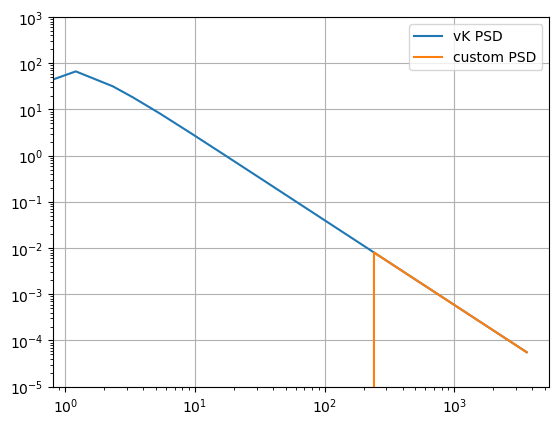

In [8]:
mphs = MyPhaseGenerator(Npix,Nmeters, outerScaleInMeters=L0, minFreq=0.1, maxFreq=30*D, dampValue=1e-8)

fMap = mphs._spatial_frequency(Npix)
psd = mphs._get_power_spectral_density(fMap)*mphs._get_scaling()

psd = np.fft.fftshift(psd)
myrad_psd, distance = computeRadialProfile(psd, Npix//2, Npix//2)

plt.figure()
plt.plot(distance, rad_psd, label='vK PSD')
plt.plot(distance, myrad_psd, label='custom PSD')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5,1e+3])

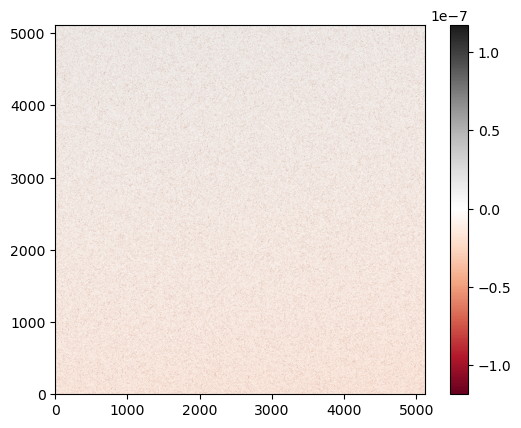

In [9]:
mphs.generate_normalized_phase_screens(1)
screen = mphs._phaseScreens[0]*phs2meters
plt.figure()
plt.imshow(screen,origin='lower',cmap='RdGy')
plt.colorbar()

In [10]:
cmask = CircularMask((screen.shape[0],screen.shape[1]),maskRadius=pixPerMeter//2)
phase = screen[~cmask.mask()]

Text(0.5, 1.0, 'PTT Filtered phase')

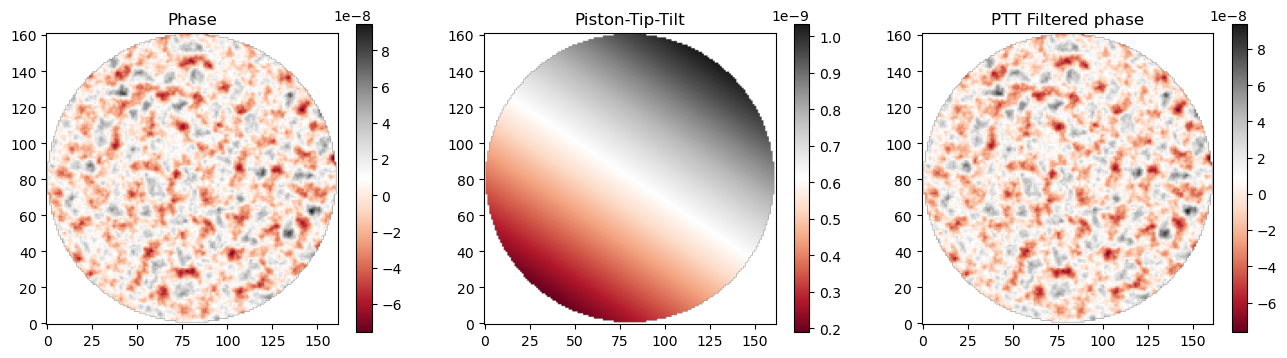

In [11]:
crop_mask = CircularMask((pixPerMeter+2,pixPerMeter+2),maskRadius=pixPerMeter//2)
image = np.zeros(crop_mask.mask().shape)
image[~crop_mask.mask()] = phase
image = np.reshape(image, crop_mask.mask().shape)

# Remove piston-tip-tilt
X,Y = np.mgrid[0:image.shape[0],0:image.shape[1]]
tilt = X[~crop_mask.mask()]
tip = Y[~crop_mask.mask()]
piston = np.ones_like(phase)
ptt = np.vstack([piston,tip,tilt]).T
phase2ptt = np.linalg.pinv(ptt)
ptt_coeffs = phase2ptt @ phase
ptt_fit = ptt @ ptt_coeffs
filt_phase = phase - ptt_fit

ptt_image = np.zeros_like(image)
ptt_image[~crop_mask.mask()] = ptt_fit
ptt_image = np.reshape(ptt_image, crop_mask.mask().shape)

filt_image = np.zeros_like(image)
filt_image[~crop_mask.mask()] = filt_phase
filt_image = np.reshape(filt_image, crop_mask.mask().shape)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(np.ma.masked_array(image,mask=crop_mask.mask()),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title('Phase')
plt.subplot(1,3,2)
plt.imshow(np.ma.masked_array(ptt_image,mask=crop_mask.mask()),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title('Piston-Tip-Tilt')
plt.subplot(1,3,3)
plt.imshow(np.ma.masked_array(filt_image,mask=crop_mask.mask()),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title('PTT Filtered phase')

In [12]:
def get_coro_psf(phase, cmask, lambdaInM, oversampling:int=4, coro:str='avg'):

    m2rad = 2*np.pi/lambdaInM
    padding_len = int(cmask.mask().shape[0]*(oversampling-1)/2)
    padded_mask = np.pad(cmask.mask(), padding_len, mode='constant', constant_values=1.0)

    image = np.zeros(padded_mask.shape)
    image[~padded_mask] = phase
    phase_2d = np.reshape(image, padded_mask.shape)

    field_amp = 1-padded_mask
    input_field = field_amp  * np.exp(1j*phase_2d*m2rad, dtype=np.complex128)

    focal_field = np.fft.fftshift(np.fft.fft2(input_field))
    psf = abs(focal_field * np.conj(focal_field))

    match coro:
        case 'ideal':
            phase_var = np.sum((phase-np.mean(phase))**2)/len(phase)
            perfect_coro_field = field_amp * (np.sqrt(np.exp(-phase_var))-np.exp(1j*phase_2d*m2rad, dtype=np.complex128))
        case 'lyot':
            fpm = CircularMask(padded_mask.shape, maskRadius=oversampling*1.75)
            pls = CircularMask(padded_mask.shape, maskRadius=cmask.mask().shape[0]//2*0.97)
            masked_ff = focal_field * fpm.mask()
            pupil_field = np.fft.ifft2(np.fft.ifftshift(masked_ff))
            perfect_coro_field = pupil_field * pls.asTransmissionValue()
            # plt.figure()
            # plt.imshow(fpm.mask(),cmap='grey')
            # plt.colorbar()
            # plt.figure()
            # plt.imshow(abs(masked_ff),cmap='grey')
            # plt.colorbar()
            # plt.figure()
            # plt.imshow(abs(pupil_field),cmap='grey')
            # plt.colorbar()
            # plt.figure()
            # plt.imshow(pls.asTransmissionValue(),cmap='grey')
            # plt.colorbar()
        case _:
            avg_electric_field = np.sum(input_field * field_amp) / np.sum(field_amp)
            perfect_coro_field = input_field - avg_electric_field * field_amp
    
    coro_focal_field = np.fft.fftshift(np.fft.fft2(perfect_coro_field))
    coro_psf = abs(coro_focal_field * np.conj(coro_focal_field))

    return psf, coro_psf

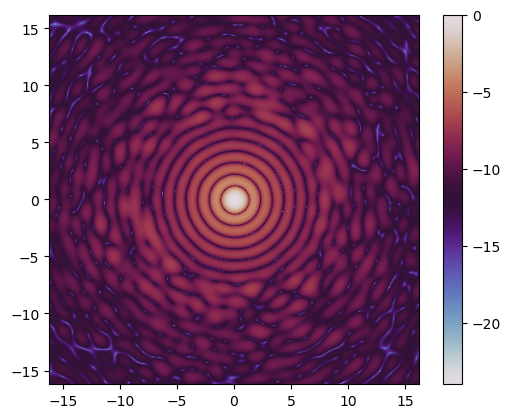

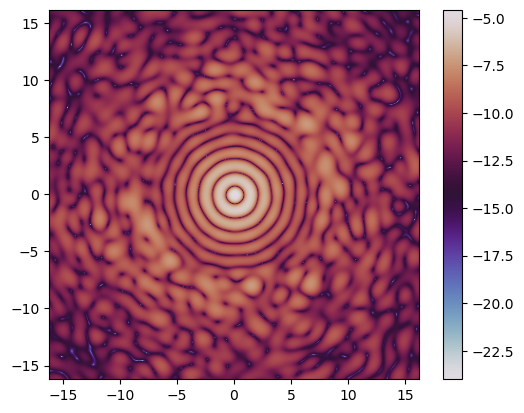

In [13]:
lambdaInM = 750e-9

oversampling=12
# psf, coro_psf = get_coro_psf(phase, crop_mask, lambdaInM=lambdaInM, oversampling=oversampling)
psf, coro_psf = get_coro_psf(filt_phase, crop_mask, lambdaInM=lambdaInM, oversampling=oversampling, coro='lyot')

plt.figure()
showZoomCenter(psf, 1/oversampling, np.max(np.log(psf)))

plt.figure()
showZoomCenter(coro_psf, 1/oversampling, np.max(np.log(psf)))


Text(0.5, 1.0, 'Raw contrast\nPSF/max(PSF(non-coro))')

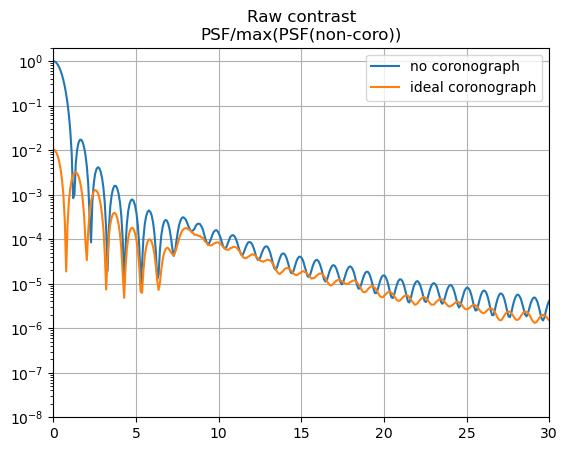

In [14]:
rad_psf, distance = computeRadialProfile(psf, psf.shape[0]//2, psf.shape[1]//2)
rad_coro_psf, _ = computeRadialProfile(coro_psf, psf.shape[0]//2, psf.shape[1]//2)


# psd = abs(np.fft.fftshift(np.fft.fft2(psf)))**2
# coro_psd = abs(np.fft.fftshift(np.fft.fft2(coro_psf)))**2

# rad_psd, _ = computeRadialProfile(psd, psd.shape[0]//2, psd.shape[1]//2)
# rad_coro_psd, _ = computeRadialProfile(coro_psd, psd.shape[0]//2, psd.shape[1]//2)

# plt.figure()
# plt.plot(distance/oversampling, rad_psd,label='no coronograph')
# plt.plot(distance/oversampling, rad_coro_psd,label='ideal coronograph')
# plt.legend()
# plt.grid()
# plt.xscale('log')
# plt.yscale('log')
# plt.title('PSD')

plt.figure()
plt.plot(distance/oversampling, rad_psf/max(rad_psf),label='no coronograph')
plt.plot(distance/oversampling, rad_coro_psf/max(rad_psf),label='ideal coronograph')
plt.legend()
plt.grid()
plt.ylim([1e-8,2])
plt.xlim([0,30])
# plt.xscale('log')
plt.yscale('log')
plt.title('Raw contrast\nPSF/max(PSF(non-coro))')

In [15]:
def average_multiple_phase_realizations(lambdaInM, N:int=100, stepX:int=1, stepY:int=1, normalizeToPefectPSF:bool=False, filter_ptt:bool=True):
    # Define mask
    crop_mask = CircularMask((pixPerMeter+2,pixPerMeter+2),maskRadius=pixPerMeter//2)
    cmask = crop_mask.mask().copy()
    image = np.zeros(cmask.shape)
    
    if filter_ptt:
        X,Y = np.mgrid[0:image.shape[0],0:image.shape[1]]
        tilt = X[~crop_mask.mask()]
        tip = Y[~crop_mask.mask()]
        piston = np.ones_like(tilt)
        ptt = np.vstack([piston,tip,tilt]).T
        phase2ptt = np.linalg.pinv(ptt)

    xx = cmask.shape[0]//2+1
    yy = cmask.shape[1]//2+1
    oversampling = 8

    psf_stack = []
    coro_psf_stack = []

    screen_mask = CircularMask((screen.shape[0],screen.shape[1]),maskRadius=pixPerMeter//2)
    phase = screen[~screen_mask.mask()]
    perfect_psf, _ = get_coro_psf(phase*0, crop_mask, lambdaInM=lambdaInM, oversampling=oversampling, coro='lyot')
    max_psf = np.max(perfect_psf)

    for jj in range(N):
        print(f'\rAtmospheric realization {jj+1:1.0f}/{N:1.0f}',end='\r',flush=True)
        xPix = int(xx+(N-jj)*stepX)
        yPix = int(yy+(N-jj)*stepY)
        screen_mask = CircularMask((screen.shape[0],screen.shape[1]),maskRadius=pixPerMeter//2,maskCenter=(xPix,yPix))
        phase = screen[~screen_mask.mask()]
        image[~cmask] = phase
        image = np.reshape(image, cmask.shape)
        if filter_ptt:
            ptt_coeffs = phase2ptt @ phase
            ptt_fit = ptt @ ptt_coeffs
            phase -= ptt_fit
        else:
            phase -= np.mean(phase)
        psf, coro_psf = get_coro_psf(phase, crop_mask, lambdaInM=lambdaInM, oversampling=oversampling, coro='lyot')
        if normalizeToPefectPSF:
            psf /= max_psf
            coro_psf /= max_psf
        psf_stack.append(psf)
        coro_psf_stack.append(coro_psf)
    psf_stack = np.asarray(psf_stack)
    coro_psf_stack = np.asarray(coro_psf_stack)
    psf_rms = np.std(psf_stack,axis=0)  
    coro_psf_rms = np.std(coro_psf_stack,axis=0)
    psf_rad_profile,dist = computeRadialProfile(psf_rms,psf_rms.shape[0]/2,psf_rms.shape[1]/2)  
    coro_psf_rad_profile,_ = computeRadialProfile(coro_psf_rms,psf_rms.shape[0]/2,psf_rms.shape[1]/2)
    pix_dist = dist/oversampling

    return psf_rad_profile, coro_psf_rad_profile, pix_dist

In [16]:
psf_rad_profile, coro_psf_rad_profile, pix_dist = average_multiple_phase_realizations(lambdaInM, N=200, normalizeToPefectPSF=True, filter_ptt=False)

In [17]:
noptt_psf_rad, noptt_coro_psf_rad, _ = average_multiple_phase_realizations(lambdaInM, N=200, normalizeToPefectPSF=True, filter_ptt=True)

Text(0.5, 1.0, 'Azimuthally averaged PSF STD\nRemoving TT')

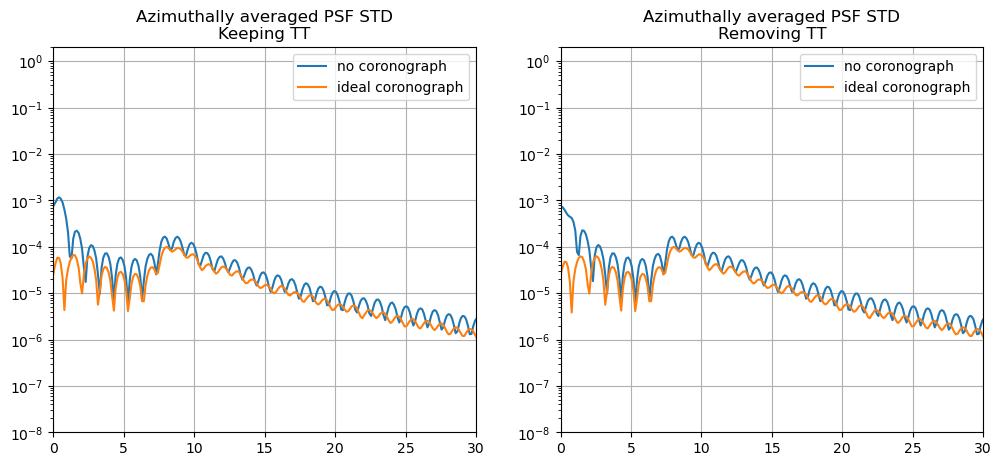

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(pix_dist, psf_rad_profile,label='no coronograph')
plt.plot(pix_dist, coro_psf_rad_profile,label='ideal coronograph')
plt.legend()
plt.grid()
plt.xlim([0,30])
plt.ylim([1e-8,2])
# plt.xscale('log')
plt.yscale('log')
plt.title('Azimuthally averaged PSF STD\nKeeping TT')
plt.subplot(1,2,2)
plt.plot(pix_dist, noptt_psf_rad,label='no coronograph')
plt.plot(pix_dist, noptt_coro_psf_rad,label='ideal coronograph')
plt.legend()
plt.grid()
plt.xlim([0,30])
plt.ylim([1e-8,2])
# plt.xscale('log')
plt.yscale('log')
plt.title('Azimuthally averaged PSF STD\nRemoving TT')